# (b) Analyze the homophily of the Cora graph dataset. 
Compute the node homophily and investigate its relationship to the predictive performance. 

Are nodes with low homophily more likely to be misclassified?

Design experiments suitable to answer these questions and present your results appropriately.


In [1]:
from torch_geometric.datasets import Planetoid
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

dataset = Planetoid(root=os.path.join('data', 'Planetoid'), name='Cora')

/Users/simon/rep/studium/graph_learning/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch_geometric.transforms import RandomNodeSplit
torch.manual_seed(42)


standard_split = RandomNodeSplit()

node_split_data = standard_split(dataset[0])

print(f"Number of training nodes: {node_split_data.train_mask.sum().item()}")
print(f"Number of validation nodes: {node_split_data.val_mask.sum().item()}")
print(f"Number of test nodes: {node_split_data.test_mask.sum().item()}")

n_features = dataset.num_node_features
n_classes = dataset.num_classes
print(f"Number of features: {n_features}")
print(f"Number of classes: {n_classes}")

Number of training nodes: 1208
Number of validation nodes: 500
Number of test nodes: 1000
Number of features: 1433
Number of classes: 7


Calculate the node homophily of the Cora dataset and print the result.

The formula for node homophily is given by:
$$
\frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \frac{ | \{ (w,v) : w
\in \mathcal{N}(v) \wedge y_v = y_w \} |  } { |\mathcal{N}(v)| }
$$

In [3]:
from torch_geometric.utils import homophily

network = dataset[0]

h = homophily(network.edge_index, network.y,method='node')
print(f"Homophily of the Cora dataset: {h:.4f}")

Homophily of the Cora dataset: 0.8252


2708
torch.Size([2708])


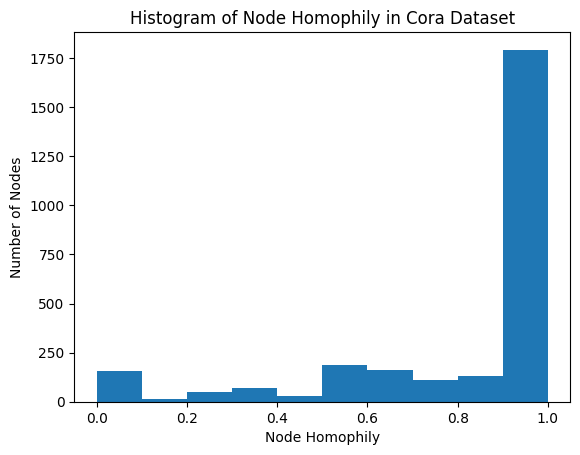

In [4]:
# get node homophily per node 
# I adapted the source code from the torch_geometric.utils.homophily function
from torch_geometric.utils import scatter


def node_homophily_per_node(network):
    row, col  = network.edge_index
    y = network.y

    out = torch.zeros(row.size(0), device=row.device)
    out[y[row] == y[col]] = 1.
    out = scatter(out, col, 0, dim_size=y.size(0), reduce='mean')

    return out

node_homos = node_homophily_per_node(network)

print(network.num_nodes)
print(node_homos.shape)
plt.hist(node_homos.cpu().numpy(), bins=10)
plt.xlabel("Node Homophily")
plt.ylabel("Number of Nodes")
plt.title("Histogram of Node Homophily in Cora Dataset")
plt.show()

In [5]:
# bin the nodes based on their homophily
node_homos_bins = np.histogram(node_homos.cpu().numpy(), bins=10)
bins = node_homos_bins[1]

# construct a mask dependent on the bin
masks = []
for i in range(bins.shape[0]-2):
    print("{0:1.1f} <= node homo <  {1:1.1f}".format(bins[i],bins[i+1]))
    masks.append(torch.logical_and((bins[i] <= node_homos), (node_homos < bins[i+1])))

print("{0:1.1f} <= node homo <= {1:1.1f}".format(bins[-2],bins[-1]))
masks.append(torch.logical_and((bins[-2] <= node_homos), (node_homos <= bins[-1])))
masks = torch.stack(masks)

# test masks:
print("Elements per bin from np.historgram:",node_homos_bins[0])
print("Elements per bin from masking:",masks.sum(dim=1))


0.0 <= node homo <  0.1
0.1 <= node homo <  0.2
0.2 <= node homo <  0.3
0.3 <= node homo <  0.4
0.4 <= node homo <  0.5
0.5 <= node homo <  0.6
0.6 <= node homo <  0.7
0.7 <= node homo <  0.8
0.8 <= node homo <  0.9
0.9 <= node homo <= 1.0
Elements per bin from np.historgram: [ 157   14   50   72   30  188  162  111  132 1792]
Elements per bin from masking: tensor([ 157,   14,   50,   72,   30,  188,  162,  111,  132, 1792])


We will use the best performing GNN from the previous exercise. 

In [6]:
# load the params and evaluation values from the last exercise
with np.load("gridsearch.npz",allow_pickle=True) as data:
    param_grid = data['param_grid']
    train_accuracies = data['train_accuracies']
    val_accuracies = data['val_accuracies']
    test_accuracies = data['test_accuracies']
    predictions = data['predictions']

# only evaluate the 10 best training runs given validation accuracy
best_i = np.flip(np.argsort(val_accuracies))
best_10 = best_i[:10]
print(val_accuracies[best_10])

[0.88  0.876 0.874 0.874 0.874 0.872 0.872 0.872 0.872 0.872]


In [7]:
# using the same seed as in the other notebook we get the same masks for splitting the data
from torch_geometric.transforms import RandomNodeSplit
torch.manual_seed(42)

standard_split = RandomNodeSplit()

node_split_data = standard_split(dataset[0])
# check if the masks are always the same when using the same seed for torch
torch.manual_seed(42)
standard_split = RandomNodeSplit()
node_split_data1 = standard_split(dataset[0])
print("Train masks are equal: {}".format((node_split_data.train_mask == node_split_data1.train_mask).all().item()))


Train masks are equal: True


In [8]:
# construct validation set masks for each homophily bin
val_masks = torch.logical_and(masks, node_split_data.val_mask)
val_masks.shape
val_masks.sum()

tensor(500)

In [9]:
# get accuracies per homophily bin
def get_accuracies_per_homophily_bin(predictions, y, val_masks):
    n_bins = val_masks.shape[0]
    n_runs = predictions.shape[0]
    acc = []
    for bin_idx in range(n_bins):
        mask = val_masks[bin_idx]
        if mask.sum() == 0:
            acc[bin_idx] = np.nan
            continue
        correct = (predictions[:, mask] == y[mask].unsqueeze(0)).sum(dim=1).cpu()
        acc.append(torch.div(correct,mask.sum()*torch.ones_like(correct)))
    return acc

val_acc_per_homophily_bin = get_accuracies_per_homophily_bin(predictions[:], dataset[0].y, val_masks)

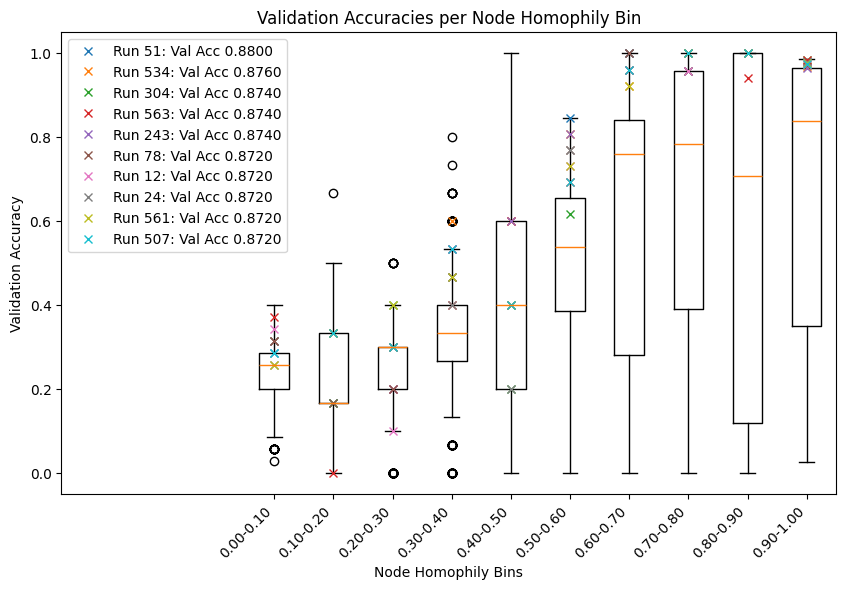

In [10]:
# do a boxplot of the accuracies per homophily bin
plt.figure(figsize=(10,6))
plt.boxplot(val_acc_per_homophily_bin, tick_labels=["{0:1.2f}-{1:1.2f}".format(bins[i], bins[i+1]) for i in range(len(bins)-1)])

# mark the 10 best runs on the boxplot
for run_idx in best_10:
    run_accs = [val_acc_per_homophily_bin[bin_idx][run_idx].item() for bin_idx in range(len(val_acc_per_homophily_bin))]
    plt.plot(range(1, len(bins)), run_accs, 'x', label="Run {}: Val Acc {:.4f}".format(run_idx, val_accuracies[run_idx]))

current_left, current_right = plt.xlim() 
# Set new limits
plt.xlim(current_left - 3.1, current_right)
# put legend in lower left corner

plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left')
plt.xlabel("Node Homophily Bins")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracies per Node Homophily Bin")
plt.show()


###  Analysis of Homophily and Predictive Performance

#### 1. Overall Homophily of Cora

* **Result:** The overall Node Homophily for the Cora dataset is approximately **0.8252** (Cell 5 output).
* **Interpretation:** A homophily score close to $1.0$ indicates that the graph is highly homophilic, meaning connected nodes tend to have the same label. The value of $0.8252$ confirms that Cora is a **highly homophilic graph**, which is typical for citation networks where linked papers usually belong to the same scientific discipline.

#### 2. Node Homophily Distribution

* **Result:** The histogram  in Cell 6 shows a highly skewed distribution, with a massive peak in the **$0.9 - 1.0$ bin**. The $1.0$ bin alone contains $1,792$ out of $2,708$ nodes.
* **Interpretation:** The majority of nodes in Cora have nearly all neighbors sharing their label. However, there is a small, but significant, portion of nodes with homophily scores below $0.5$ (heterophilic nodes).

#### 3. Relationship between Homophily and Accuracy

* **Experiment:** The boxplot  in Cell 11 displays the distribution of validation accuracies for the models across 10 bins of node homophily scores. The performance of the top 10 models (based on overall validation accuracy) is individually tracked.
* **Observation:**
    * **High Homophily ($\ge 0.8$):** All models achieve their **highest accuracy** in the $0.9-1.0$ homophily bin, often reaching $95\%-100\%$ accuracy. The $0.8-0.9$ bin also shows high performance (median accuracy above $80\%$).
    * **Low Homophily ($< 0.5$):** Performance degrades drastically for nodes with low homophily. The median accuracy in the $0.0-0.1$ bin is extremely low, and the spread of accuracy is wide, indicating high uncertainty.

#### 4. Conclusion: Are low-homophily nodes more likely to be misclassified?

* **Answer:** **Yes, indeed.** Nodes with low homophily (meaning they are connected to many nodes of different classes) are **significantly more likely to be misclassified** by the GCN.
* **Reason:** GCNs work by **aggregating information from neighbors**. In a heterophilic (low-homophily) environment, aggregating signals from neighbors with different labels introduces **noise and conflicting information** into the target node's representation, making it difficult for the classifier to correctly predict the node's true label. The models perform extremely well where the neighborhood signal is clean (high homophily) and struggle where it is mixed (low homophily).